In [160]:
import torch
import pandas as pd
import pandas as pd

import torch.nn.functional as F

from torch_geometric import nn
from torch_geometric import transforms as T
from torch_geometric.loader import LinkNeighborLoader
from torch_geometric.data import HeteroData

from sklearn.preprocessing import MinMaxScaler

In [161]:
class BookReview:
    """Book Review dataset
    Attributes:
        + user_id: user's id (0 -> 67698)
        + age: user'age
        + city: user's city location
        + state: user's state location
        + country: user's country location
        + isbn: book identify (67698 -> 138700)
        + book_title: book's title
        + book_author: book's author
        + year_of_publication: books's publication year
        + rating: the score user rate for the book
        + Summary_{1,24}: the description of book embedded by BERT
    """

    def __init__(self, path: str) -> None:
        self._path = path

    def _load_dataset(self) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
        summary_attr = [f"Summary_{i}" for i in range(1, 35)]
        user_attributes = ["user_id", "age", "city", "state", "country"]
        book_attributes = [
            "isbn",
            "book_title",
            "book_author",
            "year_of_publication",
        ] + summary_attr

        df = pd.read_csv(self._path)
        users_df = df[user_attributes].reset_index(drop=True)
        books_df = df[book_attributes].reset_index(drop=True)
        rating_df = df[["user_id", "isbn", "rating"]].reset_index(drop=True)

        return users_df, books_df, rating_df

    def __call__(self) -> HeteroData:
        data = HeteroData()
        users_df, books_df, rating_df = self._load_dataset()
        y = torch.from_numpy(rating_df["rating"].to_numpy())
        edge_index = torch.from_numpy(
            rating_df[["user_id", "isbn"]].values.transpose()
        )

        data.name = "Book rating"
        data["users"].node_id = torch.from_numpy(
            users_df["user_id"].values
        ).to(dtype=torch.int64)
        data["books"].node_id = torch.from_numpy(books_df["isbn"].values).to(
            dtype=torch.int64
        )
        data.number_of_users = len(users_df["user_id"].unique())
        data.number_of_books = len(books_df["isbn"].unique())
        books_df.drop(["isbn"], inplace=True, axis=1)
        users_df.drop(["user_id"], inplace=True, axis=1)
        data.number_of_nodes = data.number_of_users + data.number_of_books
        data.number_of_user_node_features = len(users_df.columns)
        data.number_of_book_node_features = len(books_df.columns)

        feat_users_scaler = MinMaxScaler().fit_transform(users_df.to_numpy())
        feat_books_scaler = MinMaxScaler().fit_transform(books_df.to_numpy())
        data["users"].x = torch.from_numpy(feat_users_scaler)
        data["books"].x = torch.from_numpy(feat_books_scaler)
        data["users", "rating", "books"].edge_index = edge_index
        data["users", "books"].edge_label = y
        return data

In [162]:
book_review_dataset = BookReview(
    path="../data/processed/BookReviewDataset_S.csv"
)
dataset = book_review_dataset()
dataset = T.ToUndirected()(dataset)

In [163]:
dataset

HeteroData(
  name='Book rating',
  number_of_users=6071,
  number_of_books=9731,
  number_of_nodes=15802,
  number_of_user_node_features=4,
  number_of_book_node_features=37,
  users={
    node_id=[12501],
    x=[12501, 4]
  },
  books={
    node_id=[12501],
    x=[12501, 37]
  },
  (users, rating, books)={
    edge_index=[2, 12501],
    edge_label=[12501]
  },
  (books, rev_rating, users)={
    edge_index=[2, 12501],
    edge_label=[12501]
  }
)

In [164]:
class HyperParameters:
    BATCH_SIZE = 128
    EPOCHS = 50
    LEARNING_RATE = 0.001
    DECAY = 0.0001

For the inductive model, we should split data into train and test sets. We use 80% data for training and 20% for testing. In the link prediction task, we will use the edge's information. So we use 70% for message passing and 30% for supervising. Generating negative/positive edge, we use 2:1 ratio, negative edges will generate on-the-fly

In [165]:
transform = T.RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    disjoint_train_ratio=0.3,
    neg_sampling_ratio=2.0,
    add_negative_train_samples=True,
    split_labels=True,
    edge_types=("users", "rating", "books"),
    rev_edge_types=("books", "rev_rating", "users"),
)

In [166]:
train, val, test = transform(dataset)

In [167]:
edge_label_index = train["users", "rating", "books"].pos_edge_label_index
edge_label = train["users", "rating", "books"].pos_edge_label

In [168]:
train_loader =  LinkNeighborLoader(
    data=train,
    num_neighbors=[20, 10], #get 2 hops for one node
    neg_sampling_ratio=2.0,
    edge_label_index=(("users", "rating", "books"), edge_label_index),
    edge_label=edge_label,
    batch_size=HyperParameters.BATCH_SIZE,
    shuffle=True,
)

In [169]:
val_edge_label_index = val['users', 'rating', 'books'].pos_edge_label_index
val_edge_label  = val['users', 'rating', 'books'].pos_edge_label
val_loader = LinkNeighborLoader(
    data=val,
    num_neighbors=[20, 10],
    neg_sampling_ratio=2.0,
    edge_label_index=(("users", "rating", "books"), val_edge_label_index),
    edge_label=val_edge_label,
    batch_size=HyperParameters.BATCH_SIZE,
    shuffle=True,
)

In [170]:
class BookSage(torch.nn.Module):
    def __init__(
        self,
        num_users: int,
        num_books: int,
        num_layers: int,
        hidden_channel: int,
    ) -> None:
        super(BookSage, self).__init__()
        self.embedding = torch.nn.Embedding(
            num_embeddings=num_users + num_books,
            embedding_dim=hidden_channel,
        )
        self.convs = torch.nn.ModuleList(
            nn.SAGEConv(
                in_channels=hidden_channel,
                out_channels=hidden_channel,
                aggr="max",
            )
            for _ in range(num_layers)
        )

    def forward(self, edge_index: torch.Tensor):
        emb0 = self.embedding.weight
        embs = [emb0]
        emb = emb0

        for conv in self.convs:
            emb = conv(emb, edge_index)
            embs.append(emb)
        out = torch.mean(torch.stack(embs, dim=0), dim=0)

        return emb0, out

    def encode_minibatch(
        self,
        users: torch.Tensor,
        pos_items: torch.Tensor,
        neg_items: torch.Tensor,
        edge_index: torch.Tensor,
    ):
        emb0, out = self(edge_index)
        return (
            out[users],
            out[pos_items],
            out[neg_items],
            emb0[users],
            emb0[pos_items],
            emb0[neg_items],
        )

In [171]:
class BookGCN(torch.nn.Module):
    def __init__(
        self,
        num_users: int,
        num_books: int,
        num_layers: int,
        hidden_channel: int,
    ) -> None:
        super(BookGCN, self).__init__()
        self.embedding = torch.nn.Embedding(
            num_embeddings=num_users + num_books,
            embedding_dim=hidden_channel,
        )
        self.convs = torch.nn.ModuleList(
            nn.GCNConv(
                in_channels=hidden_channel,
                out_channels=hidden_channel,
            )
            for _ in range(num_layers)
        )

    def forward(self, edge_index: torch.Tensor):
        emb0 = self.embedding.weight
        embs = [emb0]
        emb = emb0

        for conv in self.convs:
            emb = conv(emb, edge_index)
            embs.append(emb)
        out = torch.mean(torch.stack(embs, dim=0), dim=0)

        return emb0, out

    def encode_minibatch(
        self,
        users: torch.Tensor,
        pos_items: torch.Tensor,
        neg_items: torch.Tensor,
        edge_index: torch.Tensor,
    ):
        emb0, out = self(edge_index)
        return (
            out[users],
            out[pos_items],
            out[neg_items],
            emb0[users],
            emb0[pos_items],
            emb0[neg_items],
        )

In [172]:
class BookGAT(torch.nn.Module):
    def __init__(
        self,
        num_users: int,
        num_books: int,
        num_layers: int,
        hidden_channel: int,
    ) -> None:
        super(BookGAT, self).__init__()
        self.embedding = torch.nn.Embedding(
            num_embeddings=num_users + num_books,
            embedding_dim=hidden_channel,
        )
        self.convs = torch.nn.ModuleList(
            nn.GATConv(
                in_channels=hidden_channel,
                out_channels=hidden_channel,
            )
            for _ in range(num_layers)
        )

    def forward(self, edge_index: torch.Tensor):
        emb0 = self.embedding.weight
        embs = [emb0]
        emb = emb0

        for conv in self.convs:
            emb = conv(emb, edge_index)
            embs.append(emb)
        out = torch.mean(torch.stack(embs, dim=0), dim=0)

        return emb0, out

    def encode_minibatch(
        self,
        users: torch.Tensor,
        pos_items: torch.Tensor,
        neg_items: torch.Tensor,
        edge_index: torch.Tensor,
    ):
        emb0, out = self(edge_index)
        return (
            out[users],
            out[pos_items],
            out[neg_items],
            emb0[users],
            emb0[pos_items],
            emb0[neg_items],
        )

In [173]:
model = BookSage(
    num_users=train.number_of_users,
    num_books=train.number_of_books,
    num_layers=2,
    hidden_channel=64,
)

In [174]:
def compute_bpr_loss(
    users: torch.Tensor,
    users_emb: torch.Tensor,
    pos_emb: torch.Tensor,
    neg_emb: torch.Tensor,
    user_emb0: torch.Tensor,
    pos_emb0: torch.Tensor,
    neg_emb0: torch.Tensor,
):
    # compute loss from initial embeddings, used for regulization
    reg_loss = (
        (1 / 2)
        * (
            user_emb0.norm().pow(2)
            + pos_emb0.norm().pow(2)
            + neg_emb0.norm().pow(2)
        )
        / float(len(users))
    )

    # compute BPR loss from user, positive item, and negative item embeddings
    pos_scores = (users_emb * pos_emb).sum(dim=1)
    neg_scores = (users_emb * neg_emb).sum(dim=1)

    bpr_loss = torch.mean(F.softplus(neg_scores - pos_scores))

    return bpr_loss, reg_loss

In [175]:
print(model)
number_of_parameters = sum(layer.numel() for layer in model.parameters())
print(f"{number_of_parameters=:,}")

BookSage(
  (embedding): Embedding(15802, 64)
  (convs): ModuleList(
    (0-1): 2 x SAGEConv(64, 64, aggr=max)
  )
)
number_of_parameters=1,027,840


In [176]:
optimizer = torch.optim.Adam(model.parameters(), lr=HyperParameters.LEARNING_RATE)
criterion = compute_bpr_loss

In [177]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device}")

cuda


In [178]:
model = model.to(device)

In [179]:
history = {"loss": [], "val_loss": []}
for epoch in range(1, HyperParameters.EPOCHS + 1):
    epoch_losses = []
    epoch_val_losses = []
    optimizer.zero_grad()
    model.train()
    for sample in train_loader:
        sample = sample.to(device)
        (
            user_emb,
            pos_emb,
            neg_emb,
            user_emb0,
            pos_emb0,
            neg_emb0,
        ) = model.encode_minibatch(
            sample["users"].node_id,
            sample["users", "rating", "books"].pos_edge_label_index[1],
            sample["users", "rating", "books"].neg_edge_label_index[1],
            sample["users", "rating", "books"].edge_index,
        )

        bpr_loss, reg_loss = compute_bpr_loss(
            sample["users"].node_id,
            user_emb.unsqueeze(1),
            pos_emb,
            neg_emb,
            user_emb0,
            pos_emb0,
            neg_emb0,
        )
        reg_loss = reg_loss * HyperParameters.DECAY
        loss = bpr_loss + reg_loss
        epoch_losses.append(loss.item())

        loss.backward()
        optimizer.step()

    model.eval()
    for sample in val_loader:
        sample = sample.to(device)
        (
            user_emb,
            pos_emb,
            neg_emb,
            user_emb0,
            pos_emb0,
            neg_emb0,
        ) = model.encode_minibatch(
            sample["users"].node_id,
            sample["users", "rating", "books"].pos_edge_label_index[1],
            sample["users", "rating", "books"].neg_edge_label_index[1],
            sample["users", "rating", "books"].edge_index,
        )

        bpr_loss, reg_loss = compute_bpr_loss(
            sample["users"].node_id,
            user_emb.unsqueeze(1),
            pos_emb,
            neg_emb,
            user_emb0,
            pos_emb0,
            neg_emb0,
        )
        reg_loss = reg_loss * HyperParameters.DECAY
        val_loss = bpr_loss + reg_loss
        epoch_val_losses.append(val_loss.item())
    loss_mean = torch.mean(torch.tensor(epoch_losses))
    val_loss_mean = torch.mean(torch.Tensor(epoch_val_losses))
    history["loss"].append(loss_mean)
    history["val_loss"].append(val_loss_mean)
    print(
        f"Epoch {epoch}: \t Loss: {loss_mean} \t Validation loss: {val_loss_mean}"
    )

Epoch 1: 	 Loss: 8.75969409942627 	 Validation loss: 4.231352806091309
Epoch 2: 	 Loss: 7.675571441650391 	 Validation loss: 4.5018229484558105
Epoch 3: 	 Loss: 6.809762477874756 	 Validation loss: 3.4570422172546387
Epoch 4: 	 Loss: 6.17687463760376 	 Validation loss: 3.364865779876709
Epoch 5: 	 Loss: 5.390476226806641 	 Validation loss: 3.135942220687866
Epoch 6: 	 Loss: 5.160158157348633 	 Validation loss: 2.754551649093628
Epoch 7: 	 Loss: 4.071518421173096 	 Validation loss: 2.719367504119873
Epoch 8: 	 Loss: 3.5148611068725586 	 Validation loss: 2.5434927940368652
Epoch 9: 	 Loss: 3.365589141845703 	 Validation loss: 2.2603254318237305
Epoch 10: 	 Loss: 3.2702577114105225 	 Validation loss: 2.445112943649292
Epoch 11: 	 Loss: 3.2816734313964844 	 Validation loss: 2.229095935821533
Epoch 12: 	 Loss: 3.021251916885376 	 Validation loss: 2.2634997367858887
Epoch 13: 	 Loss: 2.7896993160247803 	 Validation loss: 2.1023364067077637
Epoch 14: 	 Loss: 2.6478495597839355 	 Validation lo

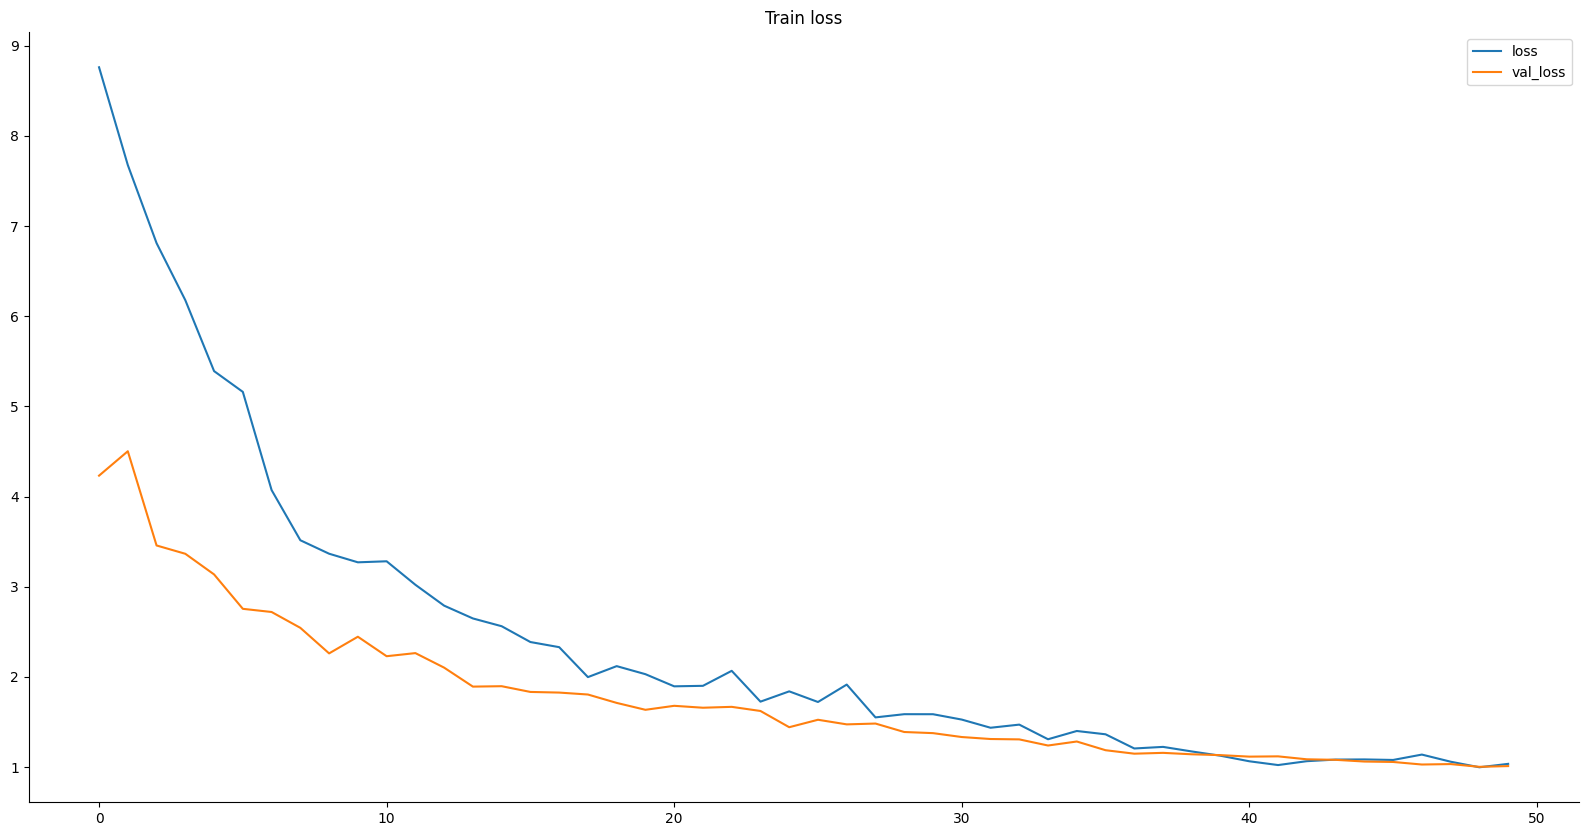

In [187]:
import matplotlib.pyplot as plt

plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.figure(figsize=(20, 10))
plt.plot(range(HyperParameters.EPOCHS), history["loss"])
plt.plot(range(HyperParameters.EPOCHS), history["val_loss"])
plt.title("Train loss")
plt.legend(["loss", "val_loss"])

In [181]:
test_edge_label_index = test['users', 'rating', 'books'].pos_edge_label_index
test_edge_label  = test['users', 'rating', 'books'].pos_edge_label
test_loader = LinkNeighborLoader(
    data=val,
    num_neighbors=[20, 10],
    neg_sampling_ratio=2.0,
    edge_label_index=(("users", "rating", "books"), test_edge_label_index),
    edge_label=test_edge_label,
    batch_size=HyperParameters.BATCH_SIZE,
    shuffle=True,
)

In [182]:
ground_truths = []
preds = []
with torch.no_grad():
    for sample in test_loader:
        sample = sample.to(device)
        (
            user_emb,
            pos_emb,
            neg_emb,
            user_emb0,
            pos_emb0,
            neg_emb0,
        ) = model.encode_minibatch(
            sample["users"].node_id,
            sample["users", "rating", "books"].pos_edge_label_index[1],
            sample["users", "rating", "books"].neg_edge_label_index[1],
            sample["users", "rating", "books"].edge_index,
        )
        ground_truth = sample["users", "rating", "books"].pos_edge_label
        pred = torch.mean((user_emb0.unsqueeze(1) * pos_emb0).sum(0), 1)
        ground_truths.append(ground_truth.cpu().numpy())
        preds.append(pred.cpu().numpy())